<a href="https://colab.research.google.com/github/jarkuszewski/NeuralNetworks/blob/main/RekaRobota.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [32]:
class NeuralNetwork:
  def __init__(self, layers, learning_rate):

    self.learning_rate = learning_rate
    self.hand_range = 50
    self.number_of_layers = len(layers)
    self.weights = list(range(self.number_of_layers))
    self.bias = list(range(self.number_of_layers))
    self.values_before_activ_func = list(range(self.number_of_layers))
    self.values_after_activ_func = list(range(self.number_of_layers))
    self.delta = list(range(self.number_of_layers))
    self.second_delta = list(range(self.number_of_layers))

    for i in range(self.number_of_layers - 1):
      self.weights[i + 1] = np.random.uniform(-0.5, 0.5, (layers[i], layers[i +1]))
      self.bias[i + 1] = np.random.uniform(-0.5, 0.5, layers[i + 1])
  
  #liczenie delty i aktualizacja wag
  #punkt 2.3 i 2.4 algorytmu -> przebiegamy wstecz

  def back_propagation(self, sample):
    self.delta[-1] = (self.values_after_activ_func[-1] - sample) * self.second_sigmoid(self.values_after_activ_func[-1])

    #liczenie delt od przedostatniej do pierwszej
    for i in reversed(range(1, self.number_of_layers - 1)):
      self.second_delta[i] = self.delta[i + 1].dot(self.weights[i + 1].T)
      self.delta[i] = self.second_delta[i] * self.second_sigmoid(self.values_after_activ_func[i])

    #aktualizacja wag
    for i in range(1, self.number_of_layers):
      self.weights[i] -= (
          self.learning_rate * np.dot(self.values_after_activ_func[i - 1].reshape(len(self.values_after_activ_func[i - 1]),1), self.delta[i].reshape(1, len(self.delta[i])))
      )
      self.bias[i] -= self.learning_rate * self.delta[i]
    
  def train(self, epochs):
    for i in range(epochs):
      sample = self.rand_radians()

      #wyliczam wejscie
      self.values_after_activ_func[0] = self.calculate_input(sample)

      #normalizacja
      self.values_after_activ_func[0] /= (self.hand_range * 2)
      sample = self.normalize_degrees(sample)

      #krok naprzod
      self.step_forward()

      #poprawianie delt
      self.back_propagation(sample)
  
  def step_forward(self):
    for i in range(1, self.number_of_layers):
      #zapamietywanie wczesniejszej wartosci dla propagacji wstecznej
      self.values_before_activ_func[i] = np.dot(self.values_after_activ_func[i - 1], self.weights[i]) + self.bias[i]
      self.values_after_activ_func[i] = self.sigmoid(self.values_before_activ_func[i])
  
  #predykcja kąta ramienia dla podanych współrzędnych
  def predict(self, input):
    #umieszczenie input w wartstwie wejściowej
    self.values_after_activ_func[0] = input
    
    #zdobywanie przewidzianych kątów
    for i in range(1, self.number_of_layers):
      self.values_before_activ_func[i] = np.dot(self.values_after_activ_func[i - 1], self.weights[i]) + self.bias[i]
      self.values_after_activ_func[i] = self.sigmoid(self.values_before_activ_func[i])
    
    #odnormalizowanie wartosci kątów
    return self.unnormalize_degrees(self.values_after_activ_func[-1])
  
  def sigmoid(self, x):
    return 1/ (1 + np.exp(-x))
  
  #pochodna funkcji aktywacji
  def second_sigmoid(self, x):
    return x * (1 - x)

  #zwracam dwa kąty w darianach(0 - Pi)
  def rand_radians(self):
    #zwracam dwa kąty z przedziału(0 -180)
    degrees = np.random.rand(2) * 180
    return np.array([np.radians(degrees[0]), np.radians(degrees[1])])

  #zwracam znormalizowanie stopnie(0.1 - 0.9)
  def normalize_degrees(self, degrees):
    norm_degrees = []
    for degree in degrees:
      norm_degrees.append(0.8 * degree / np.radians(180) + 0.1)
    return norm_degrees
  
  #cofam normalizacje(0 -180)
  def unnormalize_degrees(self, degrees):
    unnorm_degrees = []
    for degree in degrees:
      unnorm_degrees.append((degree - 0.1) * np.radians(180) / 0.8)
    return unnorm_degrees
  
  #zwracam końcowe współrzędne drugiej ręki robota
  def calculate_input(self, angles):

    #wspólrzedna x konca pierwszego ramienia - kat miedzy osia OY a pierwszym ramieniem
    xa = self.hand_range * np.sin(angles[0])
    #wspolrzedna y
    ya = -self.hand_range * np.cos(angles[0])
    #wspolrzedna x konca drugiego ramienia - kat pomiedzy pierwszym a drugim ramieniem
    xb = xa + (0 - xa) * np.cos(angles[1]) + (0 - ya) * np.sin(angles[1])
    #wspolrzedna y
    yb = ya + (0 + xa) * np.sin(angles[1]) + (0 - ya) * np.cos(angles[1])

    return np.array([xb, yb])


In [54]:
network = NeuralNetwork([2,8,8,2], 0.1)

In [55]:
network.train(500000)

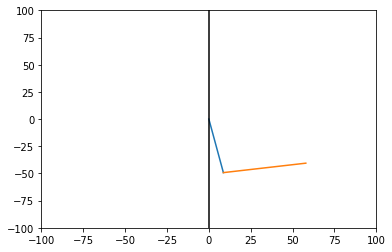

In [45]:
alpha = np.radians(10)
beta = np.radians(90)

coords = network.calculate_input([alpha, beta])
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.plot([0, network.hand_range * np.sin(alpha)], [0, -network.hand_range * np.cos(alpha)])
plt.plot([network.hand_range * np.sin(alpha), coords[0]], [-network.hand_range * np.cos(alpha), coords[1]])

plt.plot([0,0], [-100, 100], 'black')

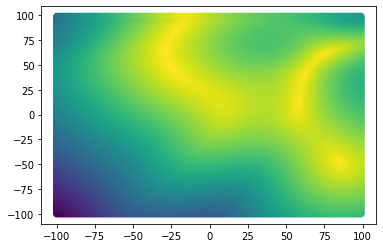

In [46]:
x = y = [i for i in range(-100, 100)]
#iloczyn kartezjanski 200x200
A = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

distance_diff = []

for i in range(len(A)):
  predicted_radians = network.predict([A[i][0] / 100, A[i][1] / 100])
  truthy_values = network.calculate_input(predicted_radians)
  #dystans miedzy przewidywana wartoscia a prawdziwa (blad)
  distance_diff.append(-np.sqrt(np.power(truthy_values[0] - A[i][0], 2) + np.power(truthy_values[1] - A[i][1], 2)))

plt.scatter(A[:,0], A[:,1], c=distance_diff)